In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 99.2 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd

test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/test1.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/train1.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203932 entries, 0 to 203931
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_id        203932 non-null  int64  
 1   date               203932 non-null  object 
 2   temperature        203932 non-null  float64
 3   precipitation      203932 non-null  float64
 4   windspeed          203932 non-null  float64
 5   humidity           203932 non-null  float64
 6   sunshine_hours     203932 non-null  float64
 7   solar_radiation    203932 non-null  float64
 8   power_consumption  203932 non-null  float64
 9   building_type      203932 non-null  object 
 10  total_floor_area   203932 non-null  float64
 11  solar_capacity     203932 non-null  float64
 12  ess_capacity       203932 non-null  float64
 13  pcs_capacity       203932 non-null  float64
 14  hour               203932 non-null  int64  
 15  dow                203932 non-null  int64  
 16  mo

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['building_type_encoded'] = le.fit_transform(train['building_type'])
test['building_type_encoded'] = le.fit_transform(test['building_type'])

print("클래스 목록:", le.classes_)
print(train[['building_type', 'building_type_encoded']].head())

클래스 목록: ['IDC(전화국)' '건물기타' '공공' '백화점' '병원' '상용' '아파트' '연구소' '학교' '호텔']
  building_type  building_type_encoded
0            호텔                      9
1            호텔                      9
2            호텔                      9
3            호텔                      9
4            호텔                      9


# 모델링

In [17]:
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','building_type',
                'power_consumption','windspeed','precipitation','date'], axis =1 )

Y = train[['power_consumption', 'building_type_encoded']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date','building_type',
                   'windspeed','precipitation', 'pred_solar_radiation', 'pred_sunshine_hours'], axis=1)

In [5]:
'''
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','building_type', 'windspeed',
                'date'], axis =1 )

Y = train[['building_type_encoded','power_consumption']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date',
                   'building_type', 'windspeed','precipitation'], axis=1)
'''

KeyError: "['building_type_encoded'] not in index"

In [18]:
cat_cols = ["building_type", "rain_bin", "wind_bin"]

for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].astype("category").cat.codes
    if col in Y.columns:
        Y[col] = Y[col].astype("category").cat.codes
    if col in test_X.columns:
        test_X[col] = test_X[col].astype("category").cat.codes


## 유형별 모델 (building_type_encoded 별 KFold + XGBoost)

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

# DMatrix용 커스텀 feval: 로그 학습이므로 expm1로 원스케일 변환 후 SMAPE 계산
def feval_smape_log(preds_log, dtrain):
    y_true_log = dtrain.get_label()
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(preds_log)
    return ('smape', smape(y_true, y_pred))

KFOLD_SPLITS = 5
RANDOM_SEED  = 42
DATA_DIR     = "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드"
target_col   = "power_consumption"

# 결과
type_list = X["building_type_encoded"].unique()
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df   = pd.DataFrame(index=Y.index,     columns=["pred"],   dtype=float)

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 유형별
for btype in type_list:
    # 유형 필터
    x_all  = X[X['building_type_encoded'] == btype].copy()
    y_all  = Y[Y['building_type_encoded'] == btype][target_col].copy()
    xt_all = test_X[test_X['building_type_encoded'] == btype].copy()

    # building_id 원핫 (train+test 합쳐 동일화)
    join = pd.concat([x_all, xt_all], axis=0, copy=False)
    join = pd.get_dummies(join, columns=["building_id"], drop_first=False)

    x  = join.iloc[:len(x_all)].copy()
    xt = join.iloc[len(x_all):].copy()

    # 불필요 열 제거
    drop_cols = ["building_type_encoded"]
    x  = x.drop(columns=[c for c in drop_cols if c in x.columns])
    xt = xt.drop(columns=[c for c in drop_cols if c in xt.columns])

    preds_valid = pd.Series(index=y_all.index, dtype=float)
    preds_test_each_fold = []

    x_values = x.values
    y_values = y_all.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그 변환
        y_tr_log = np.log1p(y_tr)
        y_va_log = np.log1p(y_va)

        # DMatrix로 구성
        dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
        dvalid = xgb.DMatrix(X_va, label=y_va_log)
        dtest  = xgb.DMatrix(xt.values)

        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 8,
            'subsample': 0.7,
            'colsample_bytree': 0.5,
            'min_child_weight': 3,
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'seed': RANDOM_SEED
        }

        # 학습 (조기종료 + 커스텀 SMAPE 평가 함께)
        evals = [(dtrain, 'train'), (dvalid, 'valid')]
        booster = xgb.train(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=5000,
                    evals=evals,
                    early_stopping_rounds=100,
                    verbose_eval=False
                    )


        # best_iteration 사용해 예측
        best_iter = booster.best_iteration
        va_pred_log = booster.predict(dvalid, iteration_range=(0, best_iter+1))
        va_pred = np.expm1(va_pred_log)

        # IndexError 방지: loc 사용
        preds_valid.loc[y_all.index[va_idx]] = va_pred

        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)


        # test 예측
        xt_pred_log = booster.predict(dtest, iteration_range=(0, best_iter+1))
        xt_pred = np.expm1(xt_pred_log)
        preds_test_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean_pred = np.mean(preds_test_each_fold, axis=0)

    # 적재
    pred_df.loc[preds_valid.index, "pred"] = preds_valid
    answer_df.loc[xt_all.index,     "answer"] = xt_mean_pred

    print(f"[{btype}] = {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape = smape(
    Y.sort_index()[target_col].values,
    pred_df.sort_index()["pred"].values
)
print(f"Total SMAPE = {total_smape:.4f}")



[9] = 4.7034
[5] = 2.1118
[4] = 2.3443
[8] = 2.4485
[1] = 4.0687
[6] = 2.9712
[7] = 3.5045
[3] = 4.3564
[0] = 1.1391
[2] = 4.5983
Total SMAPE = 3.2946


## 건물별 모델 (building_id 단위 KFold + XGBoost)

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def predict_with_best_iter(booster, dmatrix):
    """xgboost 버전별로 안전한 예측: best_iteration 있으면 그 구간만, 아니면 전체."""
    best_iter   = getattr(booster, "best_iteration", None)
    num_rounds  = getattr(booster, "num_boosted_rounds", None)
    try:
        if best_iter is not None:
            return booster.predict(dmatrix, iteration_range=(0, int(best_iter)+1))
        if num_rounds is not None and num_rounds > 0:
            return booster.predict(dmatrix, iteration_range=(0, int(num_rounds)))
    except TypeError:
        pass
    return booster.predict(dmatrix)

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

id_col     = 'building_id'
type_col   = 'building_type'
target_col = 'power_consumption'


def ensure_numeric(df, drop_cols=None):
    df = df.copy()
    if drop_cols:
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    # object/string 컬럼을 category codes로 변환
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

drop_never = ['date']

# 원본 보존을 위해 사본 생성
X_num      = ensure_numeric(X, drop_cols=drop_never)
test_X_num = ensure_numeric(test_X, drop_cols=drop_never)

# 결과
answer_df_by_building = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_by_building   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

building_numbers = X_num[id_col].unique()

# 건물별
for bnum in building_numbers:
    # 필터
    x_b  = X_num[X_num[id_col] == bnum].copy()
    y_b  = train[train[id_col] == bnum][target_col].copy()
    xt_b = test_X_num[test_X_num[id_col] == bnum].copy()

    # 표본 체크
    n_samples = len(x_b)
    if n_samples < 2 or len(y_b) < 2:
        print(f"[SKIP] Building {bnum}: too few samples (n={n_samples}).")
        continue

    # 드롭: id/타입 등 모델 입력 제외
    drop_cols = [id_col, type_col]
    x_b  = x_b.drop(columns=[c for c in drop_cols if c in x_b.columns], errors='ignore')
    xt_b = xt_b.drop(columns=[c for c in drop_cols if c in xt_b.columns], errors='ignore')

    # train/test 컬럼 일치
    xt_b = xt_b.reindex(columns=x_b.columns, fill_value=0)

    # KFold 분할 수 안전 조정
    n_splits = min(KFOLD_SPLITS, n_samples)
    if n_splits < 2:
        print(f"[SKIP] Building {bnum}: not enough data for KFold (n={n_samples}).")
        continue
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    preds_valid_b = pd.Series(index=y_b.index, dtype=float)
    preds_test_b_each_fold = []

    X_values = x_b.values
    y_values = y_b.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_values), 1):
        X_tr, X_va = X_values[tr_idx], X_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그변환
        y_tr_log = np.log1p(y_tr)
        y_va_log = np.log1p(y_va)

        # DMatrix
        dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
        dvalid = xgb.DMatrix(X_va, label=y_va_log)
        dtest  = xgb.DMatrix(xt_b.values)

        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 8,
            'subsample': 0.7,
            'colsample_bytree': 0.5,
            'min_child_weight': 3,
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'seed': RANDOM_SEED
        }

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=5000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        # best iteration 예측
        va_pred_log = predict_with_best_iter(booster, dvalid)
        va_pred     = np.expm1(va_pred_log)

        # 인덱스 안전 할당
        preds_valid_b.loc[y_b.index[va_idx]] = va_pred
        fold_scores.append(smape(y_va, va_pred))

        # test 예측
        xt_pred_log = predict_with_best_iter(booster, dtest)
        xt_pred     = np.expm1(xt_pred_log)
        preds_test_b_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean = np.mean(preds_test_b_each_fold, axis=0)

    # 결과 적재
    pred_df_by_building.loc[preds_valid_b.index, "pred"] = preds_valid_b
    answer_df_by_building.loc[xt_b.index, "answer"] = xt_mean

    print(f"Building {bnum} | XGB SMAPE(mean folds): {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape_by_building = smape(
    train.sort_index()[target_col].values,
    pred_df_by_building.sort_index()["pred"].values
)
print(f"Total SMAPE (by Building) = {total_smape_by_building:.4f}")


Building 1 | XGB SMAPE(mean folds): 6.8963
Building 2 | XGB SMAPE(mean folds): 4.7069
Building 3 | XGB SMAPE(mean folds): 1.9385
Building 4 | XGB SMAPE(mean folds): 4.3910
Building 5 | XGB SMAPE(mean folds): 1.4375
Building 6 | XGB SMAPE(mean folds): 5.6475
Building 7 | XGB SMAPE(mean folds): 5.0251
Building 8 | XGB SMAPE(mean folds): 3.4655
Building 9 | XGB SMAPE(mean folds): 4.2414
Building 10 | XGB SMAPE(mean folds): 3.9327
Building 11 | XGB SMAPE(mean folds): 2.3087
Building 12 | XGB SMAPE(mean folds): 1.7039
Building 13 | XGB SMAPE(mean folds): 2.6657
Building 14 | XGB SMAPE(mean folds): 1.8177
Building 15 | XGB SMAPE(mean folds): 2.8207
Building 16 | XGB SMAPE(mean folds): 1.8363
Building 17 | XGB SMAPE(mean folds): 2.0545
Building 18 | XGB SMAPE(mean folds): 3.3665
Building 19 | XGB SMAPE(mean folds): 5.2651
Building 20 | XGB SMAPE(mean folds): 0.8332
Building 21 | XGB SMAPE(mean folds): 1.4889
Building 22 | XGB SMAPE(mean folds): 2.5939
Building 23 | XGB SMAPE(mean folds): 7.14

## 글로벌 모델 (전체 데이터 한 번에 KFold + XGBoost)

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def predict_with_best_iter(booster, dmatrix):
    best_iter  = getattr(booster, "best_iteration", None)
    num_rounds = getattr(booster, "num_boosted_rounds", None)
    try:
        if best_iter is not None:
            return booster.predict(dmatrix, iteration_range=(0, int(best_iter)+1))
        if num_rounds is not None and num_rounds > 0:
            return booster.predict(dmatrix, iteration_range=(0, int(num_rounds)))
    except TypeError:
        pass
    return booster.predict(dmatrix)

def ensure_all_numeric(df):
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

# 어떤 ID 컬럼이 있는지 확인
id_cols_candidates = ["building_number", "building_id"]
id_col = next((c for c in id_cols_candidates if c in X.columns), None)

# 타입 컬럼도 있으면 사용
type_col = "building_type" if "building_type" in X.columns else None
target_col = "power_consumption"

# 원-핫
x_global  = X.copy()
xt_global = test_X.copy()

# building_type 더미 (있을 때만)
if type_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[type_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[type_col], drop_first=False)

# building id 더미 (있을 때만)
if id_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[id_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[id_col], drop_first=False)

# 사용하지 않을 열이 있으면 추가
drop_cols_global = ['date']
x_global  = x_global.drop(columns=[c for c in drop_cols_global if c in x_global.columns], errors='ignore')
xt_global = xt_global.drop(columns=[c for c in drop_cols_global if c in xt_global.columns], errors='ignore')

# train/test 컬럼 일치
xt_global = xt_global.reindex(columns=x_global.columns, fill_value=0)

# 혹시 남은 문자열/객체 열 숫자화
x_global  = ensure_all_numeric(x_global)
xt_global = ensure_all_numeric(xt_global)

# 타깃 정렬 (X와 같은 인덱스 순서)
y_global = train.loc[X.index, target_col].astype(float).copy()

# 결과
answer_df_global = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_global   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

preds_valid_global = pd.Series(index=y_global.index, dtype=float)
preds_test_global  = []

# KFold
n_samples = len(x_global)
n_splits  = min(KFOLD_SPLITS, n_samples)
if n_splits < 2:
    raise ValueError(f"Not enough samples for KFold: n={n_samples}")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

x_values_global = x_global.values
y_values_global = y_global.values

fold_scores_global = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values_global), 1):
    X_tr, X_va = x_values_global[tr_idx], x_values_global[va_idx]
    y_tr, y_va = y_values_global[tr_idx], y_values_global[va_idx]

    # 로그 변환
    y_tr_log = np.log1p(y_tr)
    y_va_log = np.log1p(y_va)

    # DMatrix
    dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
    dvalid = xgb.DMatrix(X_va, label=y_va_log)
    dtest  = xgb.DMatrix(xt_global.values)

    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 10,
        'subsample': 0.7,
        'colsample_bytree': 0.5,
        'min_child_weight': 3,
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'seed': RANDOM_SEED
    }

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    # 검증 예측
    va_pred_log = predict_with_best_iter(booster, dvalid)
    va_pred     = np.expm1(va_pred_log)
    preds_valid_global.iloc[va_idx] = va_pred
    fold_scores_global.append(smape(y_va, va_pred))

    # 테스트 예측
    xt_pred_log = predict_with_best_iter(booster, dtest)
    xt_pred     = np.expm1(xt_pred_log)
    preds_test_global.append(xt_pred)

# fold 평균으로 test 예측/적재
answer_df_global.loc[xt_global.index, "answer"] = np.mean(preds_test_global, axis=0)
pred_df_global.loc[preds_valid_global.index, "pred"] = preds_valid_global

print(f"Global Model : XGB SMAPE = {np.mean(fold_scores_global):.4f}")

total_smape_global = smape(
    train.sort_index()[target_col].values,
    pred_df_global.sort_index()["pred"].values
)
print(f"Total SMAPE (Global) = {total_smape_global:.4f}")


Global Model : XGB SMAPE = 3.2492
Total SMAPE (Global) = 3.2492


In [22]:
# 각 모델별 파일 생성
pred_df.to_csv(f'{DATA_DIR}/pred_valid.csv', index=False)
answer_df.to_csv(f'{DATA_DIR}/answer_test.csv', index=False)

pred_df_by_building.to_csv(f'{DATA_DIR}/pred_valid_building.csv', index=False)
answer_df_by_building.to_csv(f'{DATA_DIR}/answer_test_building.csv', index=False)

pred_df_global.to_csv(f'{DATA_DIR}/pred_valid_global.csv', index=False)
answer_df_global.to_csv(f'{DATA_DIR}/answer_test_global.csv', index=False)

In [23]:
# 파일 합치기

answer_df = pd.read_csv(f'{DATA_DIR}/answer_test.csv')
answer_df_by_building = pd.read_csv(f'{DATA_DIR}/answer_test_building.csv')
answer_df_global = pd.read_csv(f'{DATA_DIR}/answer_test_global.csv')

final_ensemble_test_pred = (
    answer_df.sort_index()["answer"].values * 1/3 +
    answer_df_by_building.sort_index()["answer"].values * 1/3 +
    answer_df_global.sort_index()["answer"].values * 1/3
)

In [24]:
final_ensemble_test_pred_fixed = [max(0, x) for x in final_ensemble_test_pred]
submission = pd.read_csv(f'{DATA_DIR}/sample_submission (1).csv')
submission['answer'] = final_ensemble_test_pred_fixed
submission.to_csv(f'{DATA_DIR}/submission.csv', index=False)

# Feature importance


In [25]:
# 필요 시: 문자열 → 숫자화
def ensure_all_numeric(df):
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

# 원-핫 등 네 파이프라인대로 만든 후…
# x_global, xt_global를 준비했다면 여기선 생략 가능
# y_global: train.loc[X.index, 'power_consumption'] 형태로 맞춰두기
feature_names = x_global.columns.tolist()


building_id_57           0.255048
building_id_85           0.232537
building_id_65           0.090360
building_id_35           0.079744
building_id_51           0.069491
building_id_56           0.042681
building_id_30           0.031414
hour_mean                0.026961
building_id_69           0.024710
building_id_43           0.019110
day_hour_mean            0.018734
building_id_55           0.017510
building_id_41           0.012967
building_id_52           0.012965
building_type_encoded    0.007872
total_floor_area         0.006296
building_id_36           0.005220
building_id_34           0.004243
day_hour_std             0.003775
cooling_ratio            0.003614
building_id_3            0.002826
has_pv                   0.002672
building_id_92           0.002590
building_id_20           0.002320
hour_std                 0.001950
building_id_10           0.001578
building_id_28           0.001532
has_ess                  0.001395
building_id_64           0.001228
building_id_89

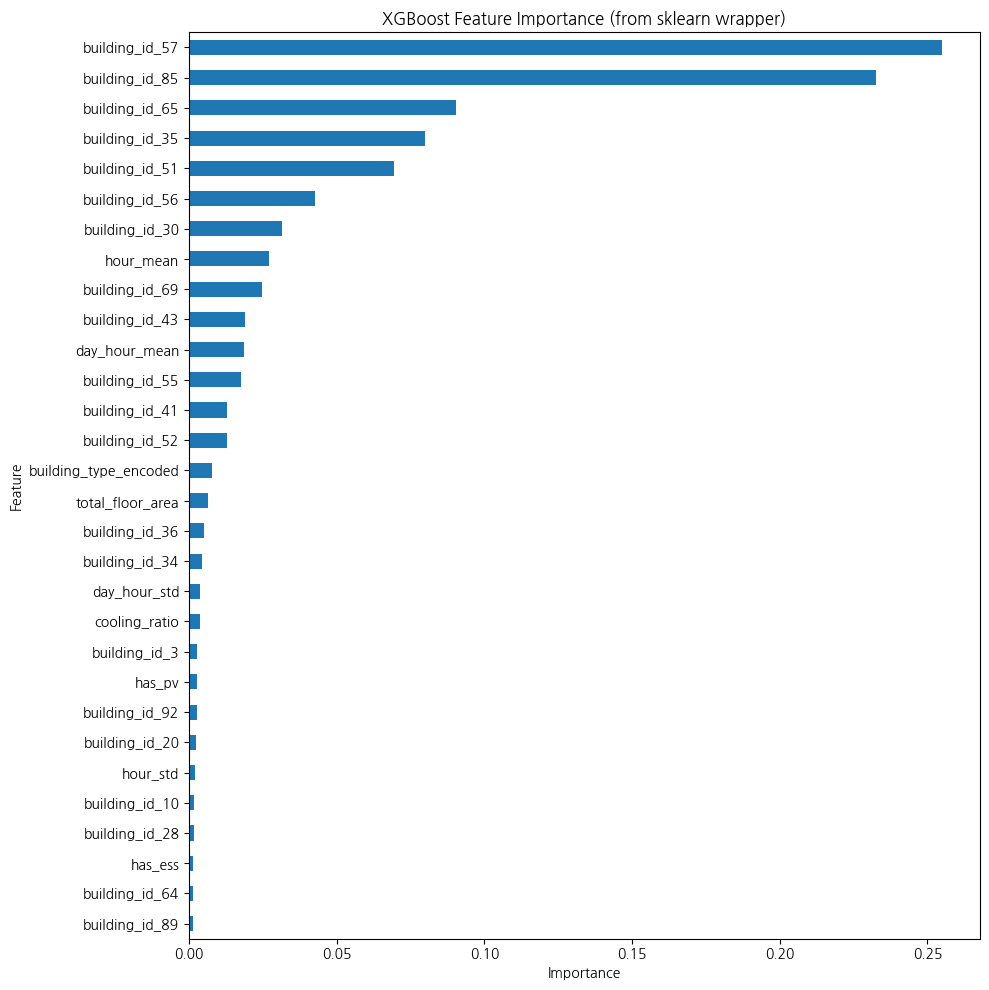

In [26]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Xmat = x_global.values
yvec = y_global.values

# 빠르게 한 번 학습 (early stopping 없이, 버전 이슈 없음)
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=600,      # 너무 크지 않게
    learning_rate=0.05,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.5,
    min_child_weight=3,
    random_state=42,
    tree_method='hist',
    eval_metric='rmse'     # fit()에 넣지 말고 생성자에 둬야 버전 이슈 없음
)

# 로그 변환을 쓸지 말지는 선택 — 중요도 순위는 크게 달라지지 않음
model.fit(Xmat, np.log1p(yvec))

# 중요도 (array 형태)
imp = model.feature_importances_
imp_s = pd.Series(imp, index=feature_names).sort_values(ascending=False)

topN = 30
print(imp_s.head(topN))

# 시각화
plt.figure(figsize=(10, max(6, int(topN*0.35))))
imp_s.head(topN).sort_values().plot(kind='barh')
plt.title("XGBoost Feature Importance (from sklearn wrapper)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Xtr, Xva, ytr, yva = train_test_split(Xmat, yvec, test_size=0.2, random_state=42)

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.5,
    min_child_weight=3,
    random_state=42,
    tree_method='hist',
    eval_metric='rmse'
)
model.fit(Xtr, np.log1p(ytr))

# permutation importance는 원래 스케일에서 평가하는 게 해석이 쉬움
def score_fn(est, X, y):
    pred = np.expm1(est.predict(X))
    # 여기선 간단히 RMSE로
    return -np.sqrt(np.mean((pred - y)**2))

r = permutation_importance(model, Xva, yva, scoring=score_fn, n_repeats=5, random_state=42)
perm_imp = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)

topN = 30
print(perm_imp.head(topN))

plt.figure(figsize=(10, max(6, int(topN*0.35))))
perm_imp.head(topN).sort_values().plot(kind='barh')
plt.title("Permutation Importance (neg RMSE, higher is better)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
